In [1]:
import sys, os
print("Kernel Python:", sys.executable)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import torch
print("PyTorch:", torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pytorch_lightning as pl

from tqdm import tqdm
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

# from esm.models.esmc import ESMC
# from esm.sdk.api import ESMProtein, LogitsConfig

Kernel Python: /zhome/c9/0/203261/miniconda3/envs/esm_gpu/bin/python
PyTorch: 2.5.1


/zhome/c9/0/203261/miniconda3/envs/esm_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [8]:
PPint_DB_encodings_list = os.listdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/ESM_C_embeddings")
encodings_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/ESM_C_embeddings"
PPint_DB_embedings = []
for file in PPint_DB_encodings_list:
    path = os.path.join(encodings_path, file)
    embedding = np.load(path)[0]
    PPint_DB_embedings.append(embedding)

In [24]:
meta_binders_embedings_list = os.listdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings")
encodings_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
meta_binders_embedings = []
for file in meta_binders_embedings_list:
    path = os.path.join(encodings_path, file)
    embedding = np.load(path)[0]
    meta_binders_embedings.append(embedding)

In [32]:
meta_targets_embedings_list = os.listdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings")
encodings_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings"
meta_targets_embedings = []
for file in meta_targets_embedings_list:
    path = os.path.join(encodings_path, file)
    embedding = np.load(path)[0]
    meta_targets_embedings.append(embedding)

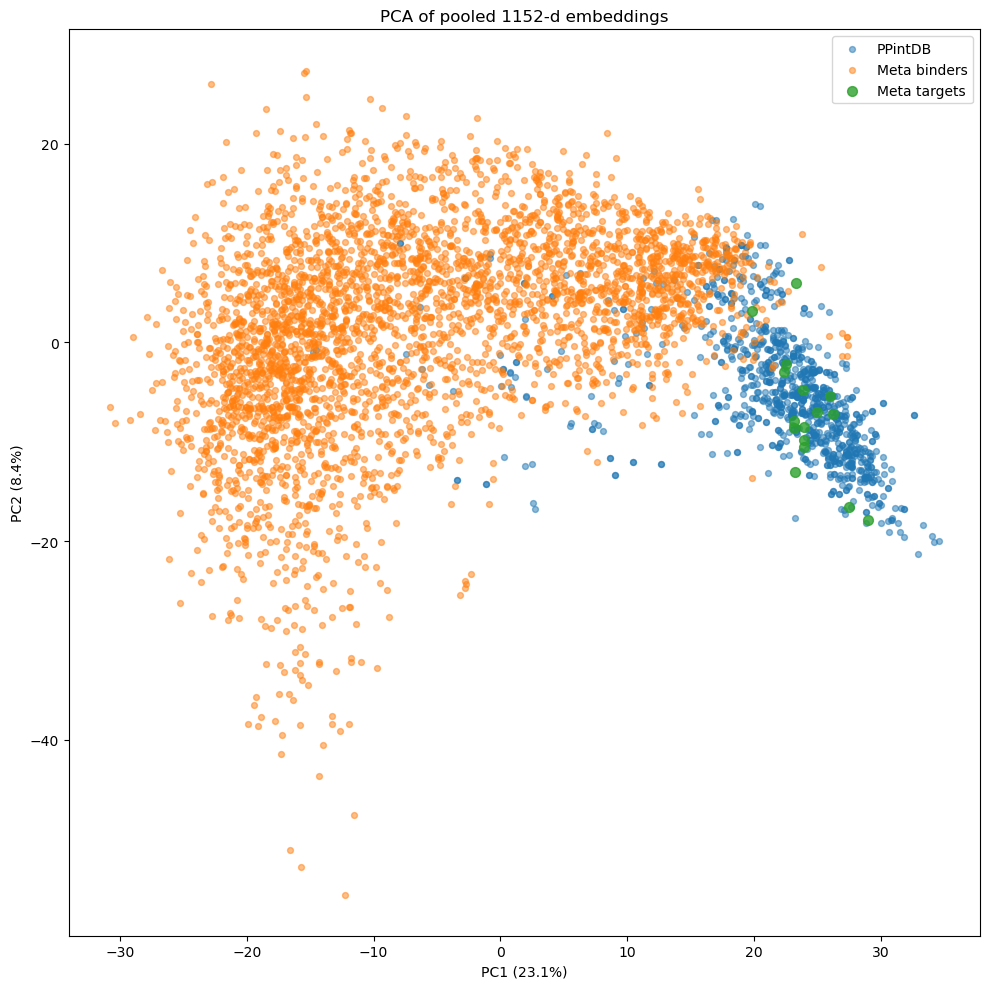

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1) Pool per-sample (mean over residues) -> (Ni, 1152)
pooled_PPintDB       = np.stack([arr.mean(axis=0) for arr in PPint_DB_embedings], axis=0)        # (N1, 1152)
pooled_meta_binders  = np.stack([arr.mean(axis=0) for arr in meta_binders_embedings], axis=0)    # (N2, 1152)
pooled_meta_targets  = np.stack([arr.mean(axis=0) for arr in meta_targets_embedings], axis=0)    # (N3, 1152)

# 2) Standardize jointly (important!)
X_all = np.vstack([pooled_PPintDB, pooled_meta_binders, pooled_meta_targets])  # (N1+N2+N3, 1152)
X_all_std = StandardScaler().fit_transform(X_all)

# 3) PCA on combined
pca = PCA(n_components=2, random_state=0)
Z_all = pca.fit_transform(X_all_std)  # (N1+N2+N3, 2)

# 4) Split back by counts
N1 = pooled_PPintDB.shape[0]
N2 = pooled_meta_binders.shape[0]
N3 = pooled_meta_targets.shape[0]

Z_PPintDB       = Z_all[:N1]
Z_meta_binders  = Z_all[N1:N1+N2]
Z_meta_targets  = Z_all[N1+N2:N1+N2+N3]   # or simply Z_all[N1+N2:]

# 5) Plot
plt.figure(figsize=(10,10))
plt.scatter(Z_PPintDB[:,0],      Z_PPintDB[:,1],      s=18, alpha=0.5, label="PPintDB",        marker='o')
plt.scatter(Z_meta_binders[:,0], Z_meta_binders[:,1], s=18, alpha=0.5, label="Meta binders",   marker='o')
plt.scatter(Z_meta_targets[:,0], Z_meta_targets[:,1], s=50, alpha=0.8, label="Meta targets",   marker='o')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of pooled 1152-d embeddings")
plt.legend()
plt.tight_layout()
plt.show()